# Import Model Architectures

Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 

# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


# Loading the Model Weights

Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device('cpu')))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device('cpu')))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

# Square Attack

This attack manipulates square-shaped regions in the feature space to generate adversarial examples. The regions are chosen and updated on a schedule, and this attack takes in hyperparameters epsilon which is the lp-radius i.e. max perturbation size, and maximum iterations

Other black box attacks query models way more times with a success rate way lower than that of white box attacks. The benefit of the square attack is that it is query efficient.

In [6]:
def test_square(model, test_loader, mnist = 1, max_iterations=500):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []
    if mnist:
        channels = 1
    else:
        channels = 3

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            

            advimages = square_attack(model, image, size=image.shape[2], channels=channels, epsilon=0.3,label=label, mnist=mnist, max_iterations=max_iterations)
            output_adv, _ = model(advimages)
            
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                # Save some adv examples for visualization later
                adv_ex = advimages.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred, prediction_adv, adv_ex) )
                
                        
            total +=1 
            print(correct, "/", total)  
            
        
    accuracy = (float(correct) / total) * 100       
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return accuracy, adv_examples

In [7]:
_, adv_examples = test_square(mnist_resnet_model, test_loader_mnist, mnist = 1)

0 / 1
1 / 2
1 / 3
2 / 4
3 / 5
4 / 6
5 / 7
5 / 8
5 / 9
5 / 10
6 / 11
7 / 12
8 / 13
9 / 14
9 / 15
9 / 16
9 / 17
10 / 18
10 / 19
10 / 20
10 / 21
11 / 22
12 / 23
13 / 24
14 / 25
14 / 26
15 / 27
16 / 28
17 / 29
17 / 30
18 / 31
18 / 32
18 / 33
19 / 34
19 / 35
20 / 36
20 / 37
21 / 38
21 / 39
21 / 40
21 / 41
22 / 42
23 / 43
23 / 44
24 / 45
24 / 46
25 / 47
26 / 48
27 / 49
28 / 50
29 / 51
29 / 52
30 / 53
30 / 54
31 / 55
32 / 56
33 / 57
33 / 58
33 / 59
33 / 60
34 / 61
35 / 62
35 / 63
36 / 64
37 / 65
37 / 66
37 / 67
37 / 68
38 / 69
39 / 70
40 / 71
41 / 72
42 / 73
42 / 74
42 / 75
42 / 76
43 / 77
44 / 78
44 / 79
44 / 80
44 / 81
45 / 82
46 / 83
47 / 84
48 / 85
49 / 86
50 / 87
51 / 88
52 / 89
53 / 90
54 / 91
55 / 92
55 / 93
56 / 94
57 / 95
58 / 96
59 / 97
59 / 98
60 / 99
61 / 100
61 / 101
62 / 102
63 / 103
64 / 104
64 / 105
64 / 106
65 / 107
66 / 108
66 / 109
67 / 110
68 / 111
68 / 112
69 / 113
69 / 114
70 / 115
70 / 116
70 / 117
71 / 118
71 / 119
71 / 120
72 / 121
73 / 122
74 / 123
74 / 124
74 / 125


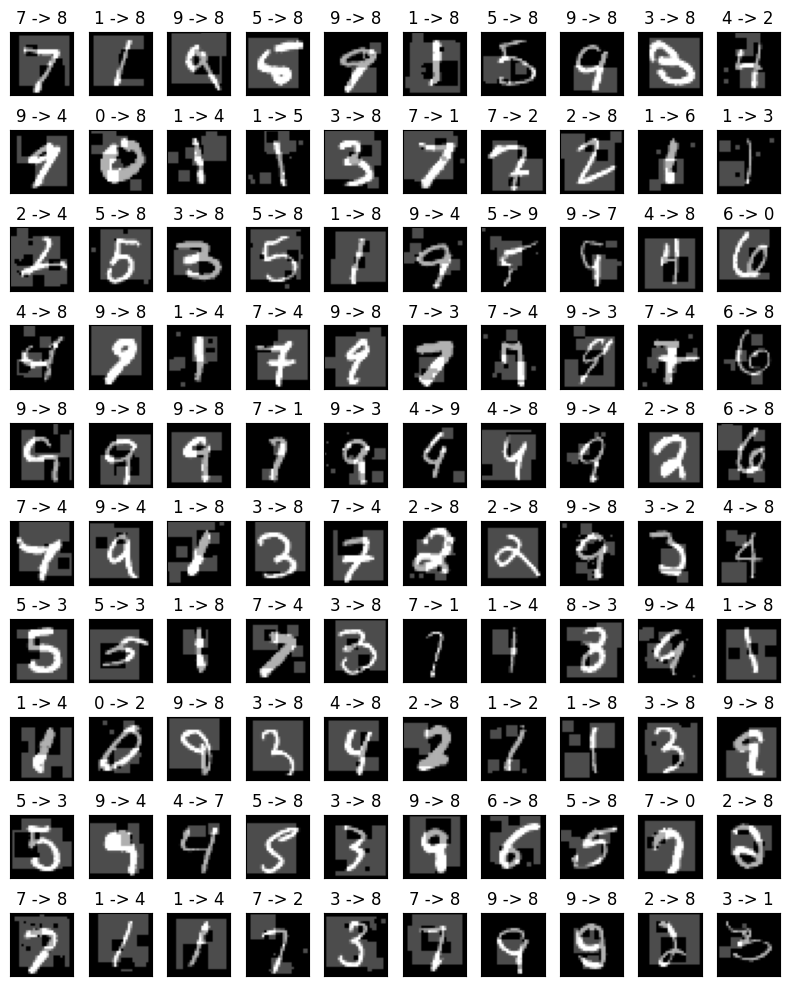

In [8]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [9]:
_, adv_examples = test_square(svhn_resnet_model, test_loader_svhn, mnist = 0)

0 / 1
1 / 2
1 / 3
1 / 4
1 / 5
1 / 6
1 / 7
1 / 8
2 / 9
3 / 10
3 / 11
4 / 12
5 / 13
5 / 14
6 / 15
6 / 16
6 / 17
6 / 18
7 / 19
8 / 20
9 / 21
10 / 22
11 / 23
11 / 24
12 / 25
13 / 26
14 / 27
14 / 28
15 / 29
15 / 30
15 / 31
16 / 32
16 / 33
17 / 34
17 / 35
18 / 36
19 / 37
20 / 38
20 / 39
21 / 40
21 / 41
21 / 42
21 / 43
21 / 44
21 / 45
21 / 46
21 / 47
22 / 48
22 / 49
23 / 50
24 / 51
25 / 52
26 / 53
26 / 54
27 / 55
27 / 56
27 / 57
27 / 58
27 / 59
27 / 60
27 / 61
27 / 62
27 / 63
27 / 64
27 / 65
27 / 66
27 / 67
27 / 68
27 / 69
27 / 70
27 / 71
27 / 72
28 / 73
29 / 74
29 / 75
30 / 76
30 / 77
30 / 78
31 / 79
31 / 80
31 / 81
31 / 82
31 / 83
31 / 84
31 / 85
31 / 86
31 / 87
32 / 88
32 / 89
32 / 90
32 / 91
33 / 92
33 / 93
33 / 94
33 / 95
34 / 96
34 / 97
35 / 98
35 / 99
36 / 100
37 / 101
37 / 102
38 / 103
39 / 104
40 / 105
41 / 106
42 / 107
42 / 108
42 / 109
43 / 110
44 / 111
45 / 112
46 / 113
46 / 114
46 / 115
47 / 116
47 / 117
47 / 118
47 / 119
48 / 120
48 / 121
49 / 122
50 / 123
51 / 124
51 / 125
52 /

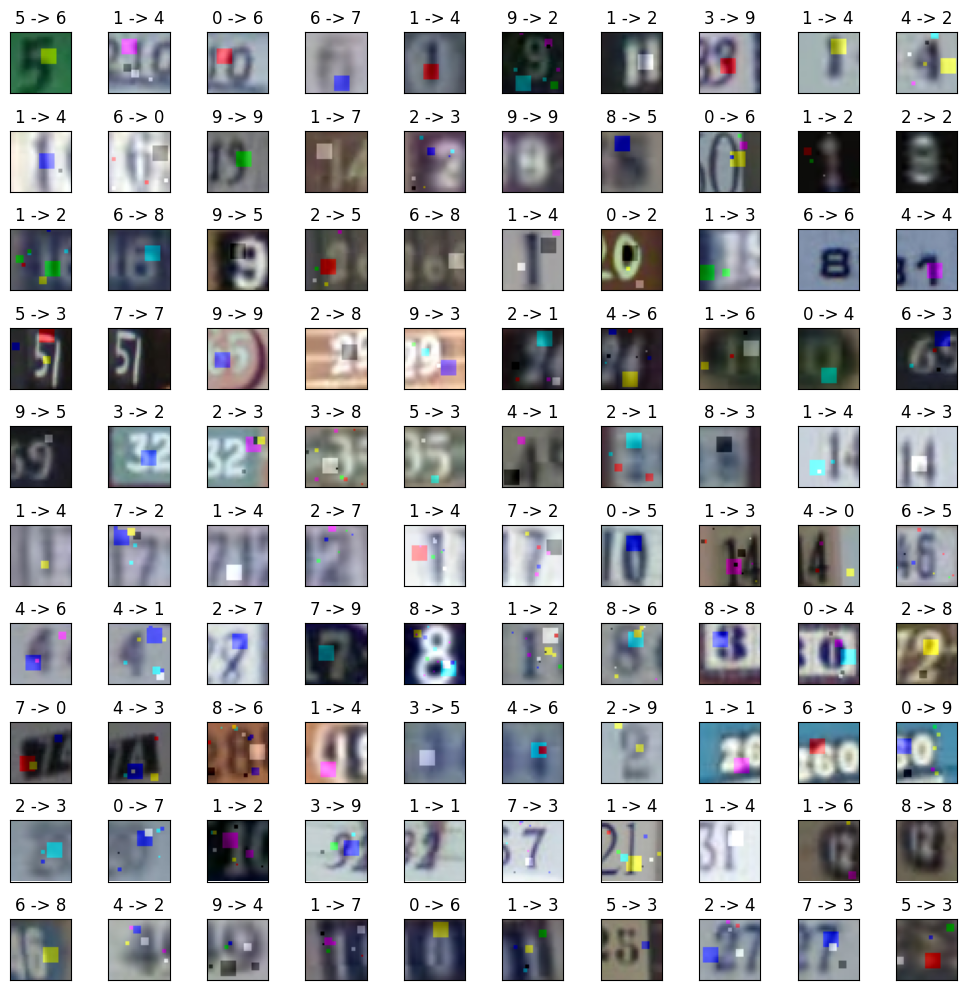

In [10]:
adv_examples = adv_examples[:100]
plt.figure(figsize=(10, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex # /255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [11]:
_, adv_examples = test_square(cifar_resnet_model, test_loader_cifar10, mnist = 0)

1 / 1
1 / 2
1 / 3
1 / 4
1 / 5
2 / 6
3 / 7
3 / 8
3 / 9
4 / 10
4 / 11
5 / 12
5 / 13
6 / 14
7 / 15
7 / 16
8 / 17
8 / 18
8 / 19
9 / 20
9 / 21
9 / 22
9 / 23
10 / 24
10 / 25
10 / 26
11 / 27
11 / 28
11 / 29
12 / 30
13 / 31
13 / 32
13 / 33
13 / 34
14 / 35
14 / 36
14 / 37
14 / 38
15 / 39
15 / 40
15 / 41
16 / 42
16 / 43
16 / 44
16 / 45
17 / 46
17 / 47
17 / 48
17 / 49
17 / 50
18 / 51
18 / 52
18 / 53
18 / 54
18 / 55
18 / 56
18 / 57
18 / 58
18 / 59
18 / 60
19 / 61
19 / 62
19 / 63
19 / 64
19 / 65
19 / 66
19 / 67
19 / 68
19 / 69
19 / 70
19 / 71
19 / 72
20 / 73
20 / 74
20 / 75
21 / 76
21 / 77
21 / 78
21 / 79
22 / 80
23 / 81
23 / 82
24 / 83
24 / 84
24 / 85
24 / 86
25 / 87
25 / 88
26 / 89
27 / 90
28 / 91
28 / 92
29 / 93
30 / 94
30 / 95
30 / 96
30 / 97
30 / 98
31 / 99
31 / 100
31 / 101
32 / 102
33 / 103
33 / 104
34 / 105
35 / 106
35 / 107
36 / 108
37 / 109
38 / 110
38 / 111
39 / 112
39 / 113
39 / 114
39 / 115
39 / 116
40 / 117
40 / 118
40 / 119
40 / 120
40 / 121
40 / 122
41 / 123
41 / 124
41 / 125
41 / 1

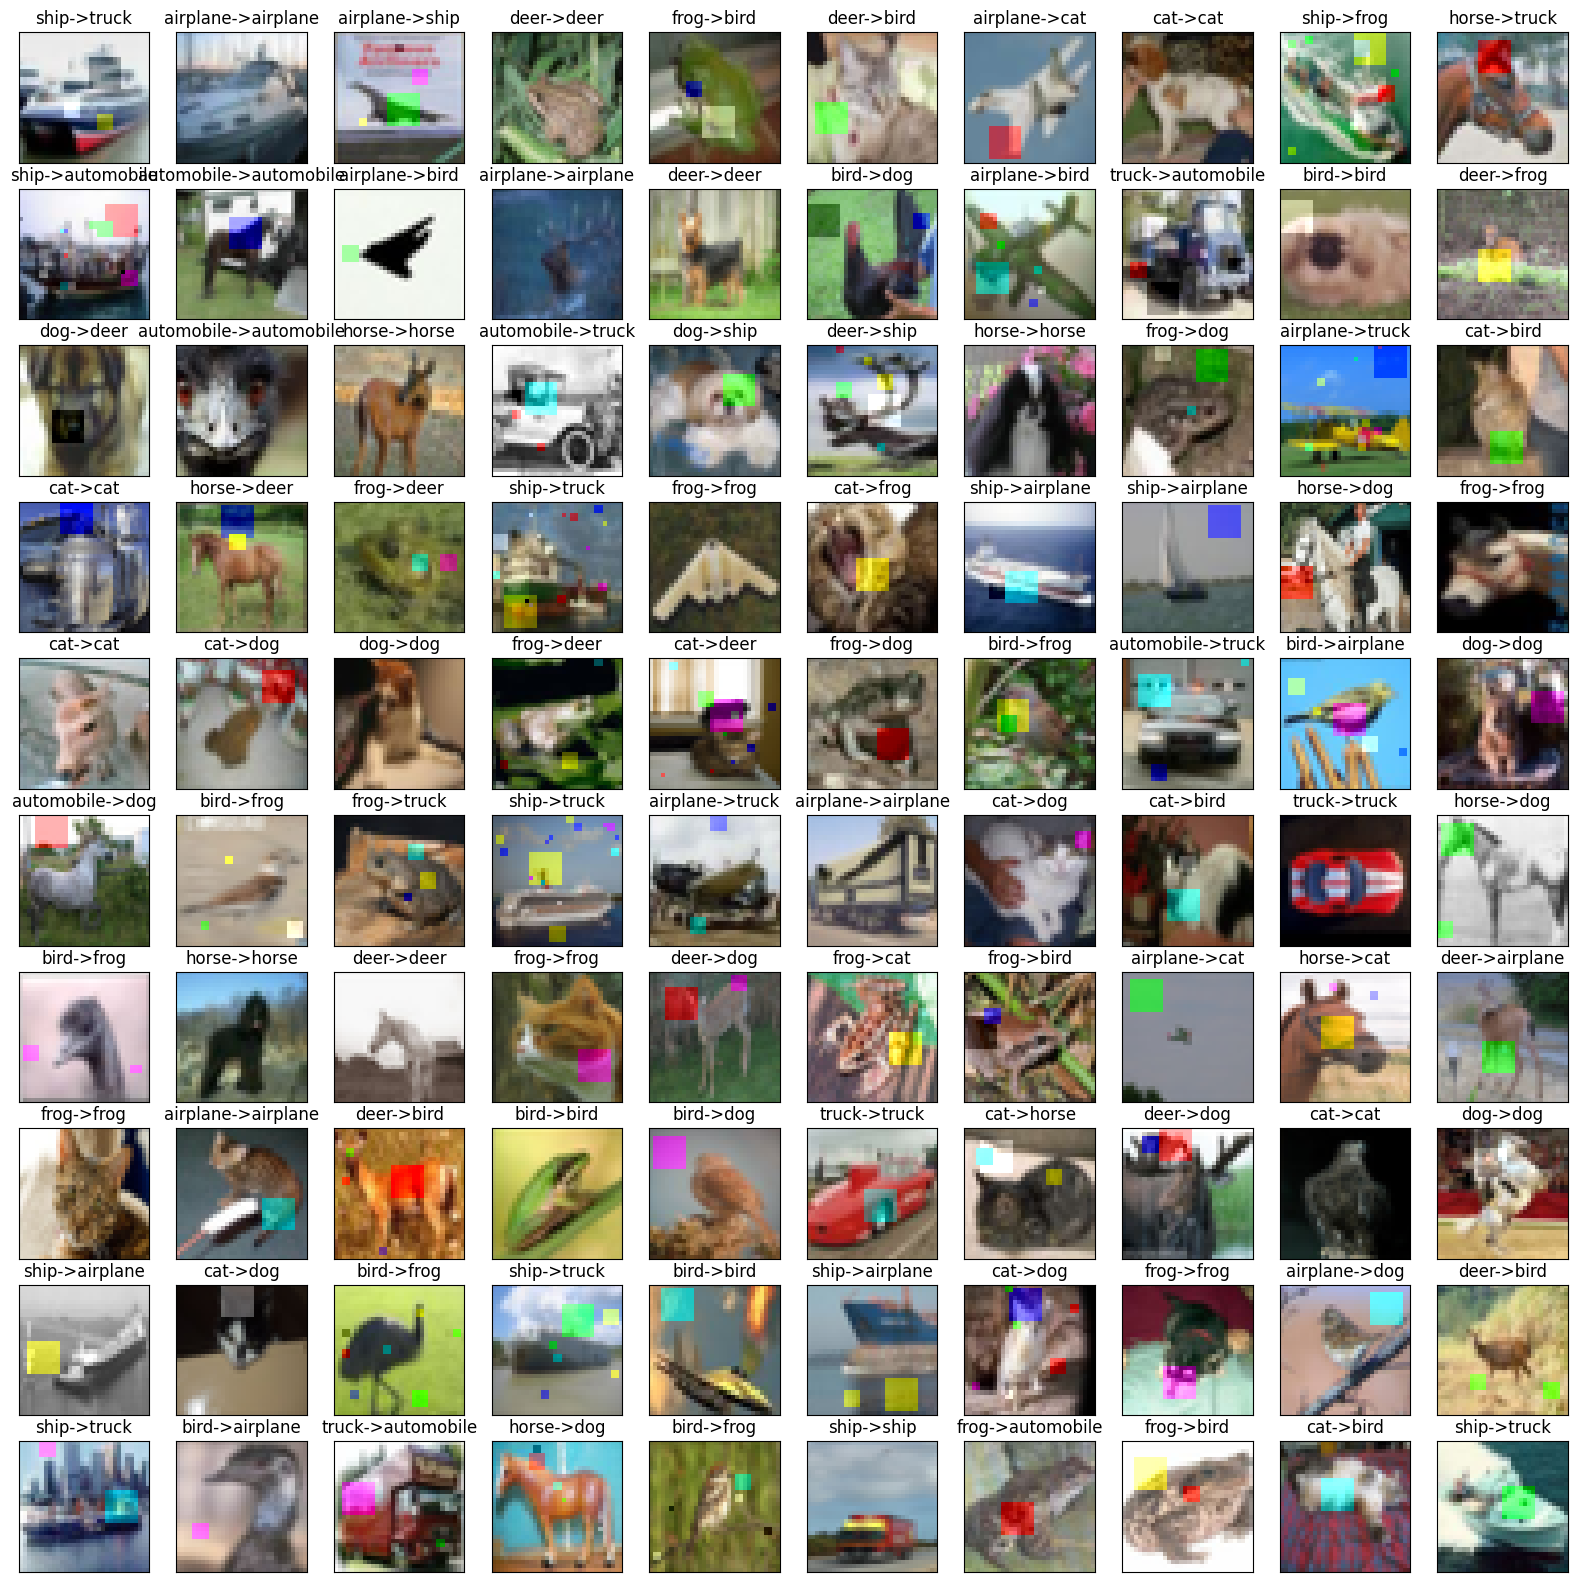

In [12]:
# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
adv_examples = adv_examples[:100]
plt.figure(figsize=(20, 20))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    ex = ex  # Normalizing pixel values
    plt.title(f"{label_mapping[orig.item()]}->{label_mapping[adv.item()]}")
    plt.imshow(ex)

plt.show()
